# Problem Statement - Predicting the trailing 28 day number of thefts at a given location.

Group 10 - Thibault Clement, Kuo, Sheng Peng, Mohan, Shriraksha, Parthasarathy, Sathyanarayanan, Sharma, Rijul

**Introduction**

This study aims to analyze patterns of theft from vehicles in Toronto, focusing on long-term trend analysis and predictive modeling. The analysis will focus on 3 main areas:

1. Examining trend components through moving averages to understand long-term changes.
2. Determining whether there are significant differences in theft incident rates across various types of locations.
3. Developing a predictive model to forecast the likelihood of theft incidents based on specific time periods or locations.

By analyzing data from Toronto's Open Data portal, this study will provide insights into crime patterns that could be valuable for law enforcement resource allocation and crime prevention strategies. The predictive model will help in forecasting theft incidents, which can be used to optimize patrol scheduling and resource allocation to high-risk areas.

This dataset includes all Theft from Motor Vehicle occurrences by reported date. The Theft from Motor Vehicle offences include Theft from Motor Vehicle Under and Theft from Motor Vehicle Over. This data is provided at the offence and/or victim level, therefore one occurrence number may have several rows of data associated to the various offences used to categorize the occurrence.

This data does not include occurrences that have been deemed unfounded. The definition of unfounded according to Statistics Canada is: “It has been determined through police investigation that the offence reported did not occur, nor was it attempted” (Statistics Canada, 2020).

This data includes all MCI occurrences reported to the Toronto Police Service, including those where the location has not been able to be verified. As a result, coordinate fields may appear blank. Likewise, this includes occurrences where the coordinate location is outside the City of Toronto.

**Objective**
We aim to predict the trailing 28-day number of thefts at a given location. 

To do this:

1. Aggregate and compute the number of thefts per location over time.
2. Create a 28-day trailing count for each location.
3. Develop a regression model to predict the trailing 28-day theft count.

**Initial Analysis of Dataset**

In [32]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score

In [33]:
# Load data
theft_from_moto_vehicle = pd.read_csv('theft-from-motor-vehicle - 4326.csv',index_col=0)
theft_from_moto_vehicle.head()

,EVENT_UNIQUE_ID,REPORT_DATE,OCC_DATE,REPORT_YEAR,REPORT_MONTH,REPORT_DAY,REPORT_DOY,REPORT_DOW,REPORT_HOUR,OCC_YEAR,...,LOCATION_TYPE,PREMISES_TYPE,UCR_CODE,UCR_EXT,OFFENCE,MCI_CATEGORY,HOOD_158,LONG_WGS84,LAT_WGS84,geometry
_id,,,,,,,,,,,,,,,,,,,,,
1,GO-20141261501,2014-01-01,2014-01-01,2014,January,1,1,Wednesday,8,2014.0,...,"Single Home, House (Attach Garage, Cottage, Mo...",House,2142,200,Theft From Motor Vehicle Under,NonMCI,073,-79.374531,43.657067,"{""type"": ""MultiPoint"", ""coordinates"": [[-79.37..."
2,GO-20141261988,2014-01-01,2013-12-31,2014,January,1,1,Wednesday,11,2013.0,...,"Parking Lots (Apt., Commercial Or Non-Commercial)",Outside,2142,200,Theft From Motor Vehicle Under,NonMCI,168,-79.376550,43.662052,"{""type"": ""MultiPoint"", ""coordinates"": [[-79.37..."
3,GO-20141263347,2014-01-01,2014-01-01,2014,January,1,1,Wednesday,17,2014.0,...,"Single Home, House (Attach Garage, Cottage, Mo...",House,2142,200,Theft From Motor Vehicle Under,NonMCI,130,-79.277162,43.817307,"{""type"": ""MultiPoint"", ""coordinates"": [[-79.27..."
4,GO-20141262045,2014-01-01,2013-12-31,2014,January,1,1,Wednesday,16,2013.0,...,"Parking Lots (Apt., Commercial Or Non-Commercial)",Outside,2142,200,Theft From Motor Vehicle Under,NonMCI,071,-79.376704,43.662420,"{""type"": ""MultiPoint"", ""coordinates"": [[-79.37..."
5,GO-20149000010,2014-01-01,2013-12-31,2014,January,1,1,Wednesday,0,2013.0,...,"Parking Lots (Apt., Commercial Or Non-Commercial)",Outside,2142,200,Theft From Motor Vehicle Under,NonMCI,031,-79.451306,43.723657,"{""type"": ""MultiPoint"", ""coordinates"": [[-79.45..."


**DATA DICTIONARY**

| Column | Description |
|--------|-------------|
| _id | Unique row identifier for Open Data database |
| EVENT_UNIQUE_ID | Offence Number |
| REPORT_DATE | Date Offence was Reported |
| OCC_DATE | Date of Offence |
| REPORT_YEAR | Year Offence was Reported |
| REPORT_MONTH | Month Offence was Reported |
| REPORT_DAY | Day of the Month Offence was Reported |
| REPORT_DOY | Day of the Year Offence was Reported |
| REPORT_DOW | Day of the Week Offence was Reported |
| REPORT_HOUR | Hour Offence was Reported |
| OCC_YEAR | Year Offence Occurred |
| OCC_MONTH | Month Offence Occurred |
| OCC_DAY | Day of the Month Offence Occurred |
| OCC_DOY | Day of the Year Offence Occurred |
| OCC_DOW | Day of the Week Offence Occurred |
| OCC_HOUR | Hour Offence Occurred |
| DIVISION | Police Division where Offence Occurred |
| LOCATION_TYPE | Location Type of Offence |
| PREMISES_TYPE | Premises Type of Offence |
| UCR_CODE | UCR Code for Offence |
| UCR_EXT | UCR Extension for Offence |
| OFFENCE | Title of Offence |
| MCI_CATEGORY | MCI Category of Occurrence |
| HOOD_158 | Identifier of Neighbourhood using City of Toronto's new 158 neighbourhood structure |
| LONG_WGS84 | Longitude coordinate |
| LAT_WGS84 | Latitude coordinate |
| geometry | geometry |

The dataset contains records of motor vehicle theft incidents in Toronto. It includes the following relevant columns:

1. REPORT_DATE: The date the theft was reported.
2. OCC_DATE: The date the theft occurred.
3. LOCATION_TYPE and PREMISES_TYPE: The type of location or premises where the theft occurred.
4. LONG_WGS84 and LAT_WGS84: Geographic coordinates of the incident.
5. HOOD_158: Indicates the neighborhood or region.


In [34]:
# Check data types
theft_from_moto_vehicle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96276 entries, 1 to 96276
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   EVENT_UNIQUE_ID  96276 non-null  object 
 1   REPORT_DATE      96276 non-null  object 
 2   OCC_DATE         96276 non-null  object 
 3   REPORT_YEAR      96276 non-null  int64  
 4   REPORT_MONTH     96276 non-null  object 
 5   REPORT_DAY       96276 non-null  int64  
 6   REPORT_DOY       96276 non-null  int64  
 7   REPORT_DOW       96276 non-null  object 
 8   REPORT_HOUR      96276 non-null  int64  
 9   OCC_YEAR         96257 non-null  float64
 10  OCC_MONTH        96257 non-null  object 
 11  OCC_DAY          96257 non-null  float64
 12  OCC_DOY          96257 non-null  float64
 13  OCC_DOW          96257 non-null  object 
 14  OCC_HOUR         96276 non-null  int64  
 15  DIVISION         96276 non-null  object 
 16  LOCATION_TYPE    96276 non-null  object 
 17  PREMISES_TYPE    

In [35]:
# Check null values
theft_from_moto_vehicle.isna().sum()

EVENT_UNIQUE_ID       0
REPORT_DATE           0
OCC_DATE              0
REPORT_YEAR           0
REPORT_MONTH          0
REPORT_DAY            0
REPORT_DOY            0
REPORT_DOW            0
REPORT_HOUR           0
OCC_YEAR             19
OCC_MONTH            19
OCC_DAY              19
OCC_DOY              19
OCC_DOW              19
OCC_HOUR              0
DIVISION              0
LOCATION_TYPE         0
PREMISES_TYPE         0
UCR_CODE              0
UCR_EXT               0
OFFENCE               0
MCI_CATEGORY          0
HOOD_158              0
LONG_WGS84         1141
LAT_WGS84          1141
geometry              0
dtype: int64

Note: we will keep the null values for the exploratory analysis

In [36]:
# Convert dates to datetime format for easier manipulation
theft_from_moto_vehicle['REPORT_DATE'] = pd.to_datetime(theft_from_moto_vehicle['REPORT_DATE'], errors='coerce')
theft_from_moto_vehicle['OCC_DATE'] = pd.to_datetime(theft_from_moto_vehicle['OCC_DATE'], errors='coerce')

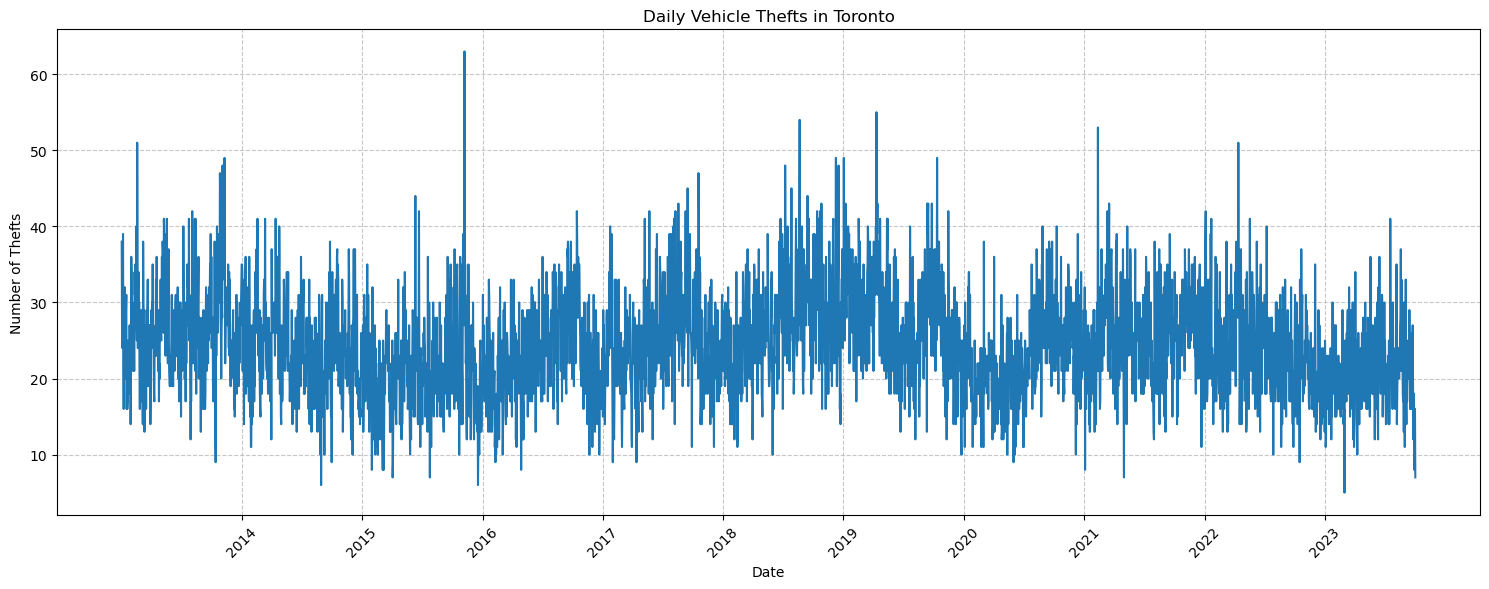

In [37]:
# Plot daily counts
daily_counts = theft_from_moto_vehicle.groupby('OCC_DATE').size().reset_index(name='count')
daily_counts = daily_counts.set_index('OCC_DATE')
daily_counts = daily_counts['2014-01-01':]
plt.figure(figsize=(15, 6))
plt.plot(daily_counts.index, daily_counts)
plt.title('Daily Vehicle Thefts in Toronto')
plt.xlabel('Date')
plt.ylabel('Number of Thefts')
years = pd.date_range(start=daily_counts_t28d.index.min(), end=daily_counts_t28d.index.max(), freq='A')
plt.xticks(years, labels=[str(year.year) for year in years], rotation=45)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

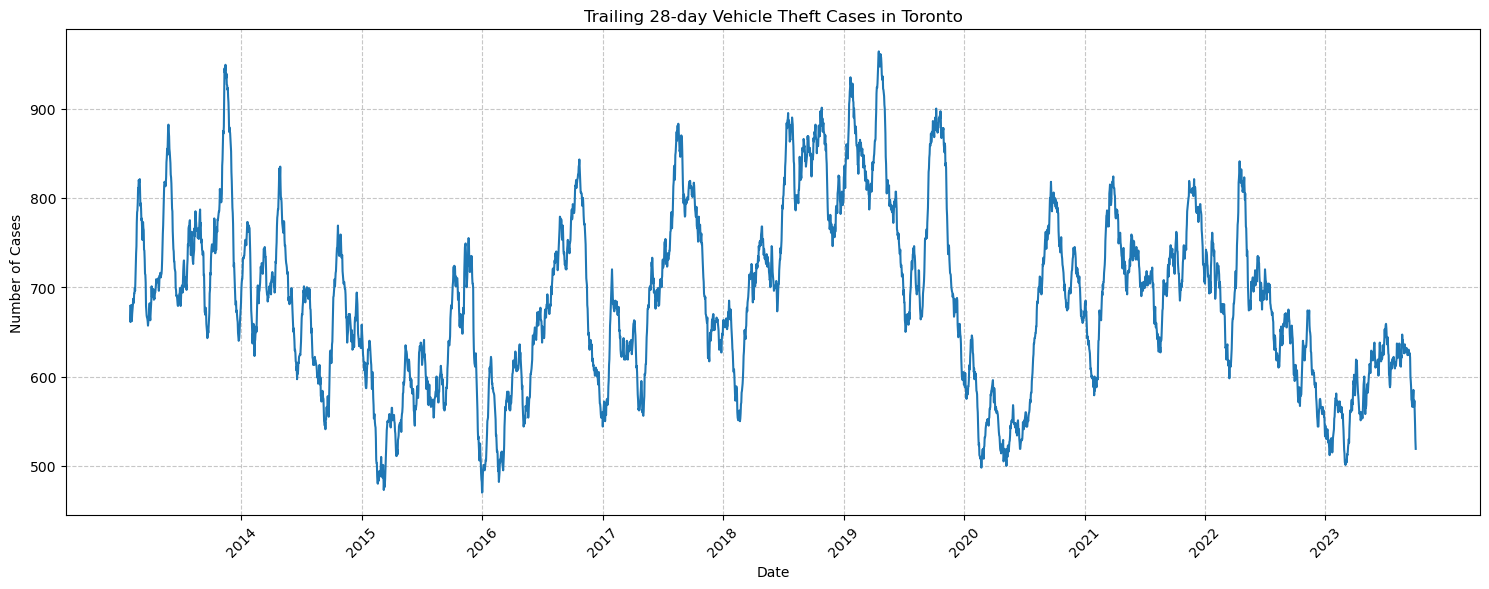

In [38]:
# Plot trailing 28-day counts
daily_counts_t28d = daily_counts['count'].rolling(28).sum()
daily_counts_t28d = daily_counts_t28d.dropna()
plt.figure(figsize=(15, 6))
plt.plot(daily_counts_t28d.index, daily_counts_t28d)
plt.title('Trailing 28-day Vehicle Theft Cases in Toronto')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
years = pd.date_range(start=daily_counts_t28d.index.min(), end=daily_counts_t28d.index.max(), freq='A')
plt.xticks(years, labels=[str(year.year) for year in years], rotation=45)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Looking at trailing 28-day allows us to better visualize trends over the long run by removing noise driven by day of the week or short-term fluctuations. We can observe several significant patterns and trends that warrant attention. The data reveals notable fluctuations over time, with a particularly striking peak around 2020. This peak was followed by a substantial decline, possibly influenced by societal changes during the COVID-19 pandemic. The temporal pattern doesn't show a consistent seasonal cycle, but rather exhibits distinct phases of increase and decrease over the years. The most recent data points (2023-2024) indicate a downward trend in theft cases. This declining pattern could be attributed to various factors such as improved security measures, law enforcement strategies, or broader socioeconomic changes in the region.

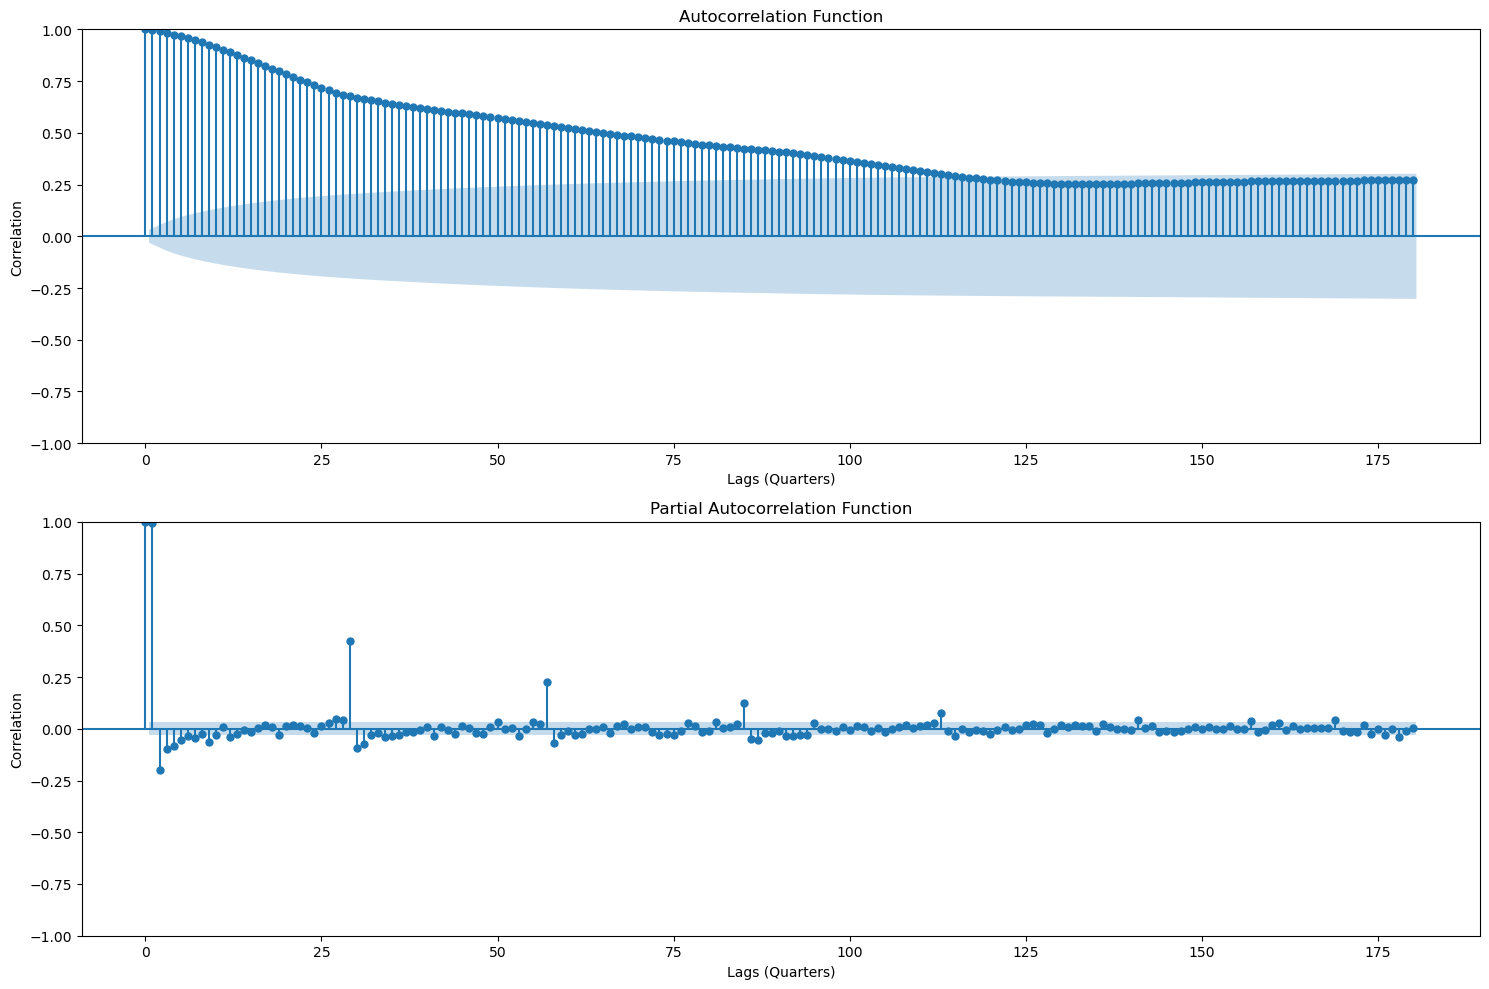

In [39]:
# Autocorellation analysis (trailing 28-day)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

plot_acf(daily_counts_t28d, lags=180, ax=ax1)
ax1.set_title('Autocorrelation Function')
ax1.set_xlabel('Lags (Quarters)')
ax1.set_ylabel('Correlation')

plot_pacf(daily_counts_t28d, lags=180, ax=ax2)
ax2.set_title('Partial Autocorrelation Function')
ax2.set_xlabel('Lags (Quarters)')
ax2.set_ylabel('Correlation')

plt.tight_layout()
plt.show()

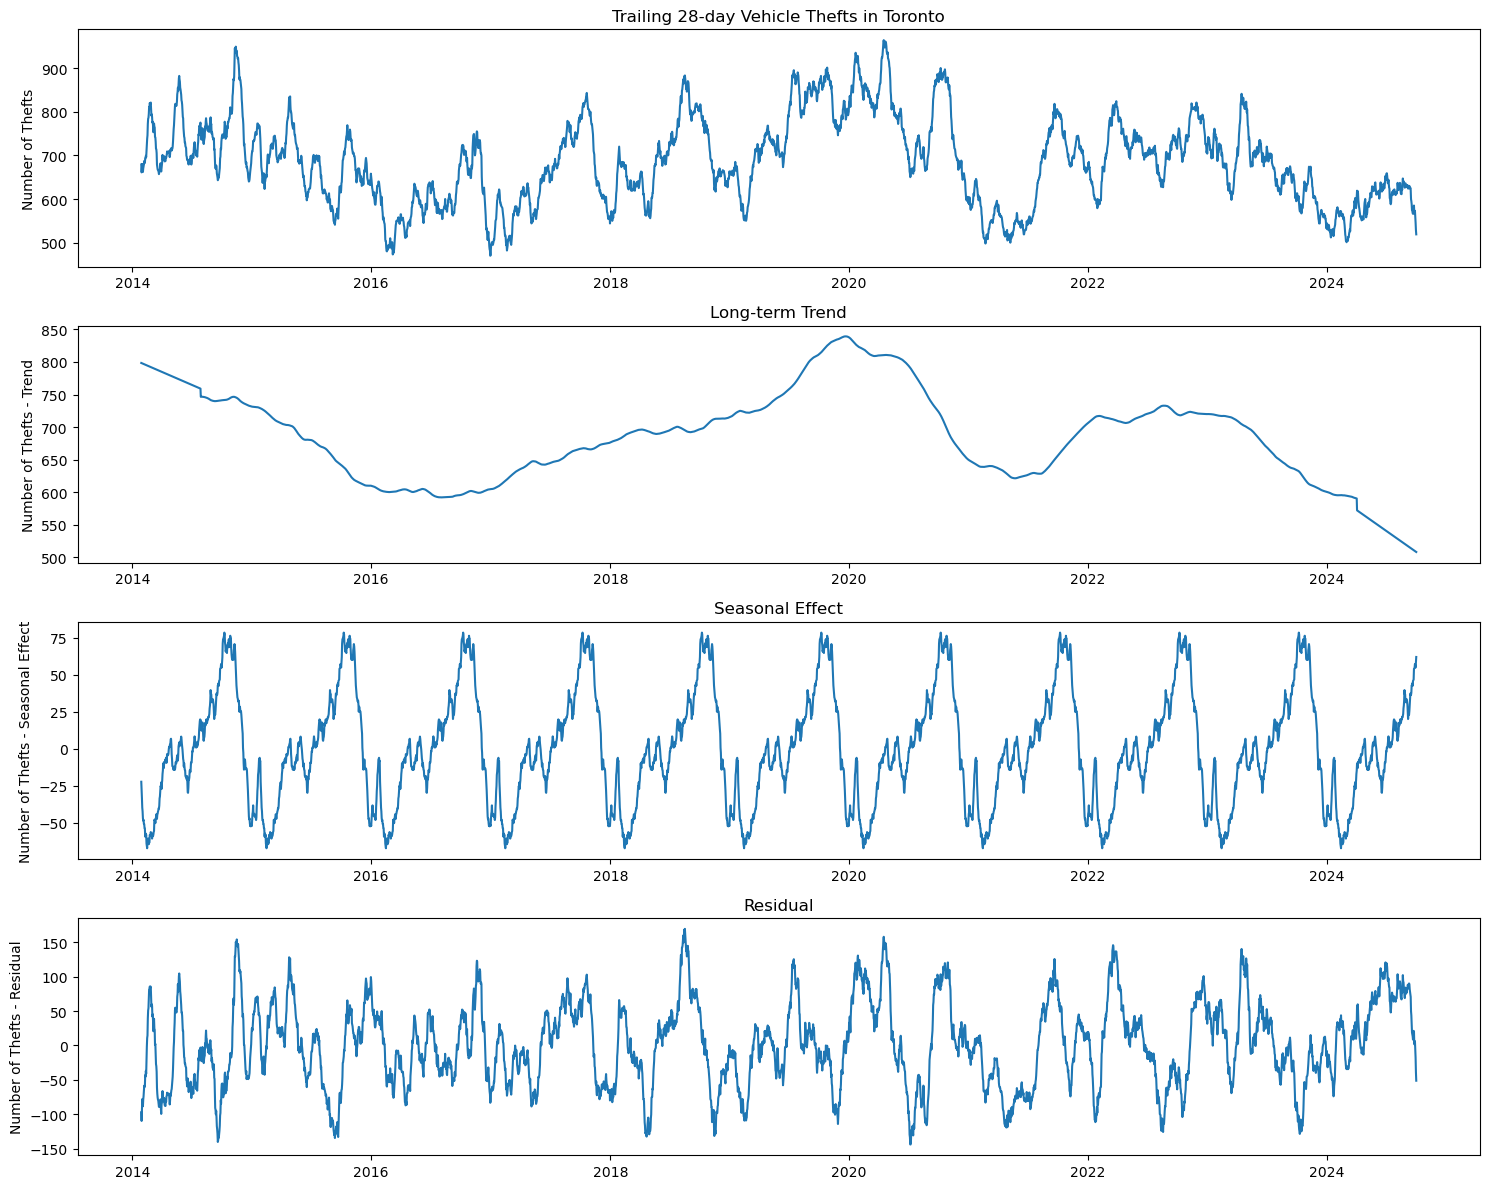


Component Statistics:

Trend:
count    3899.000000
mean      684.711525
std        70.822442
min       508.199738
25%       629.647945
50%       691.663014
75%       725.771233
max       839.312329
Name: trend, dtype: float64

Seasonal:
count    3899.000000
mean       -0.459940
std        37.684037
min       -67.342339
25%       -26.410768
50%        -4.014562
75%        23.989643
max        78.514115
Name: seasonal, dtype: float64

Residual:
count    3899.000000
mean        1.227255
std        60.571007
min      -143.886498
25%       -42.839214
50%         0.210901
75%        43.709318
max       169.318016
Name: resid, dtype: float64


In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(
    daily_counts_t28d,
    period=365,            
    model='additive',
    extrapolate_trend='freq'
)

plt.figure(figsize=(15, 12))

plt.subplot(411)
plt.plot(daily_counts_t28d.index, daily_counts_t28d)
plt.title('Trailing 28-day Vehicle Thefts in Toronto')
plt.ylabel('Number of Thefts')

plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Long-term Trend')
plt.ylabel('Number of Thefts - Trend')

plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonal Effect')
plt.ylabel('Number of Thefts - Seasonal Effect')

plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residual')
plt.ylabel('Number of Thefts - Residual')

plt.tight_layout()
plt.show()

print("\nComponent Statistics:")
print("\nTrend:")
print(decomposition.trend.describe())
print("\nSeasonal:")
print(decomposition.seasonal.describe())
print("\nResidual:")
print(decomposition.resid.describe())

An issue arises because the rolling operation generates results with an index that doesn't align perfectly with the original DataFrame. This happens because rolling computations are aligned with the group index rather than the row index.

To resolve this, the index is reset after the rolling computation before reintegrating the result into the DataFrame. 

In [41]:
# Drop rows with invalid or missing dates
theft_from_moto_vehicle = theft_from_moto_vehicle.dropna(subset=['REPORT_DATE', 'OCC_DATE'])

# Group data by location (longitude and latitude) and report date, and count incidents
theft_data_updated = (
    theft_from_moto_vehicle.groupby(['LONG_WGS84', 'LAT_WGS84', 'REPORT_DATE'])
    .size()
    .reset_index(name='incident_count')
)

# Sort data for trailing computation
theft_data_updated = theft_data_updated.sort_values(by=['LONG_WGS84', 'LAT_WGS84', 'REPORT_DATE'])

# Calculate a 28-day trailing sum of incidents for each location
theft_data_updated['trailing_28_day_count'] = (
    theft_data_updated.groupby(['LONG_WGS84', 'LAT_WGS84'])['incident_count']
    .rolling(window=28, min_periods=1)
    .sum()
    .reset_index(level=[0, 1], drop=True)  # Drop group index and align with original DataFrame index
)

# Display the first few rows of the processed data to verify the fix
print(theft_data_updated.head())


   LONG_WGS84  LAT_WGS84 REPORT_DATE  incident_count  trailing_28_day_count
0  -79.639247  43.749844  2014-04-07               1                    1.0
1  -79.639247  43.749844  2022-11-06               1                    2.0
2  -79.636525  43.747750  2014-02-14               1                    1.0
3  -79.636525  43.747750  2020-08-19               1                    2.0
4  -79.636525  43.747750  2020-10-16               1                    3.0


The data has been processed successfully by doing the following:

1. Grouped by location and date: Aggregated the number of incidents (incident_count) at each unique location (longitude, latitude) and date.
2. Calculated a 28-day trailing count: For each location, a rolling window of 28 days was used to compute the cumulative number of incidents.

Next, we'll prepare the data for regression analysis by using the trailing 28-day count as the target variable and identifying potential predictors.

**Regression Analysis**

Based on the data above, the independent variables and dependant variables are identified. 

Dependent Variable - 
1. Trailing 28 Day Count (Number of Thefts)

Independent Variables - 
1. Location of thefts 
2. Report Date

In [42]:
# Add potential predictors
# Extract date-based features
theft_data_updated['year'] = theft_data_updated['REPORT_DATE'].dt.year
theft_data_updated['month'] = theft_data_updated['REPORT_DATE'].dt.month
theft_data_updated['day_of_week'] = theft_data_updated['REPORT_DATE'].dt.dayofweek

# Define features (predictors) and the target variable
features = ['LONG_WGS84', 'LAT_WGS84', 'year', 'month', 'day_of_week']
target = 'trailing_28_day_count'

# Split into predictors (X) and target (y)
X = theft_data_updated[features]
y = theft_data_updated[target]

# Display a summary of the predictors and target
X.describe(), y.describe()


(         LONG_WGS84     LAT_WGS84          year         month   day_of_week
 count  91585.000000  91585.000000  91585.000000  91585.000000  91585.000000
 mean     -79.399637     43.706966   2018.868494      6.489032      2.754392
 std        0.104854      0.052441      3.067328      3.378124      1.990679
 min      -79.639247     43.586487   2014.000000      1.000000      0.000000
 25%      -79.477101     43.661714   2016.000000      4.000000      1.000000
 50%      -79.397330     43.700066   2019.000000      7.000000      3.000000
 75%      -79.327106     43.751445   2021.000000      9.000000      4.000000
 max      -79.122044     43.853164   2024.000000     12.000000      6.000000,
 count    91585.000000
 mean         8.625124
 std          9.248225
 min          1.000000
 25%          2.000000
 50%          4.000000
 75%         12.000000
 max         52.000000
 Name: trailing_28_day_count, dtype: float64)

In [43]:
# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Train a linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the model summary 
print("Model Coefficients:") 
for feature, coef in zip(features, regressor.coef_): 
    print(f"{feature}: {coef}") 
    
print(f"Intercept: {regressor.intercept_}") 
print(f"Mean Squared Error: {mse}")
print(f"R2: {r2}")


Model Coefficients:
LONG_WGS84: -2.988805041990855
LAT_WGS84: -18.025408711355844
year: 1.0311466289672606
month: 0.046575159239569786
day_of_week: 0.06941676260750906
Intercept: -1523.0906789120602
Mean Squared Error: 74.76059674210995
R2: 0.12281226436693926


A linear regression model was trained on the predictors to predict the trailing 28-day theft count. The model's performance was evaluated using Mean Squared Error (MSE).

**Conclusion**